In [3]:
import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime
import os
import logging
from pprint import pprint

import plotly.express as px
import plotly.graph_objects as go

import gym
import gym.spaces

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (11.5,6)
plt.style.use('ggplot')

logger = logging.getLogger(__name__)

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [4]:
db_link ="/home/mateusz/Desktop/Moje_repo/My-Data-Science-repository/Stock_data_project/mWIG40/WIG40/WIG40/WIG.db"
conn = sqlite3.connect(db_link)

df = pd.read_sql('SELECT * FROM WIG',
            conn)

dates = [datetime.strptime(x, "%d-%m-%Y") for x in df["date"]]
df["date"] = dates

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317185 entries, 0 to 317184
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    317185 non-null  datetime64[ns]
 1   ticker  317185 non-null  object        
 2   open    317185 non-null  float64       
 3   MAX     317185 non-null  float64       
 4   MIN     317185 non-null  float64       
 5   close   317185 non-null  float64       
 6   volume  317185 non-null  float64       
 7   trade   317185 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 19.4+ MB


In [7]:
df.head()

,date,ticker,open,MAX,MIN,close,volume,trade
0,2022-01-14,MAGNA POLONIA SPOLKA AKCYJNA,3.17,3.175,3.055,3.17,31747.0,98868.0
1,2022-01-13,MAGNA POLONIA SPOLKA AKCYJNA,3.20,3.200,3.140,3.17,10047.0,31692.0
2,2022-01-12,MAGNA POLONIA SPOLKA AKCYJNA,3.18,3.190,3.115,3.19,15092.0,47669.0
3,2022-01-11,MAGNA POLONIA SPOLKA AKCYJNA,3.14,3.190,3.100,3.10,21381.0,66695.0
4,2022-01-10,MAGNA POLONIA SPOLKA AKCYJNA,3.25,3.270,3.100,3.19,36051.0,114582.0


In [43]:
df_list = []
for i in df.ticker.unique():
    df_x = df.loc[df["ticker"]==i] 
    df_x.name = i
    df_x=df_x.drop_duplicates()
    df_to_append=df_x.set_index("date")
    df_list.append(df_to_append[["ticker","open", "MAX", "MIN", "close", "trade"]])
    
df_list.sort(key=lambda x:len(x), reverse=True)
[(df.ticker.iloc[0],df.index[-1], df.index[0]) for df in df_list]

[('BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('BENEFIT SYSTEMS SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('BUDIMEX SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('GRUPA AZOTY SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('BIOTON SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('WIELTON SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('VIVID GAMES SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('VISTULA RETAIL GROUP SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('TRAKCJA PRKII SPOLKA AKCYJNA',
  Timestamp('2016-01-04 00:00:00'),
  Timestamp('2022-01-14 00:00:00')),
 ('TAURON POLSKA ENERGIA SPOLKA AKCYJNA

In [1]:
dfs1= [df for df in df_list if df.index.min()<datetime.strptime('01-01-2019', "%d-%m-%Y") and df.index.max()>=datetime.strptime('14-01-2022', "%d-%m-%Y")]

NameError: name 'df_list' is not defined

In [45]:
dfs1

[                                              ticker   open    MAX    MIN  \
 date                                                                        
 2022-01-14  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  63.50  64.00  62.60   
 2022-01-13  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  63.50  64.00  62.80   
 2022-01-12  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  63.60  64.40  63.10   
 2022-01-11  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  63.70  65.00  62.90   
 2022-01-10  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  64.50  64.50  62.20   
 ...                                              ...    ...    ...    ...   
 2016-01-11  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  67.66  67.66  66.02   
 2016-01-08  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  67.30  68.24  66.00   
 2016-01-07  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  67.60  68.23  65.26   
 2016-01-05  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  70.39  70.95  67.90   
 2016-01-04  BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA  71.00  72

In [50]:
df3 = pd.concat(dfs1, axis=0)
df3 = df3.reset_index()
df3.head()

,date,ticker,open,MAX,MIN,close,trade
0,2022-01-14,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,63.5,64.0,62.6,63.5,3428522.0
1,2022-01-13,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,63.5,64.0,62.8,63.5,1863309.0
2,2022-01-12,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,63.6,64.4,63.1,63.5,2647519.0
3,2022-01-11,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,63.7,65.0,62.9,63.0,5591732.0
4,2022-01-10,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,64.5,64.5,62.2,63.5,2819247.0


In [51]:
df2 = df3.sort_values("date", ascending=True)
#df2 = df2.groupby(["ticker"])
df2.head()

,date,ticker,open,MAX,MIN,close,trade
171421,2016-01-04,ZUE SPOLKA AKCYJNA,8.80,8.80,8.15,8.51,20070.0
9047,2016-01-04,WIELTON SPOLKA AKCYJNA,7.20,7.20,7.10,7.20,17017.0
222343,2016-01-04,PGF POLSKA GRUPA FOTOWOLTAICZNA SPOLKA AKCYJNA,0.48,0.50,0.48,0.49,15681.0
116063,2016-01-04,GI GROUP POLAND SPOLKA AKCYJNA,13.60,14.57,13.60,14.00,8844.0
262292,2016-01-04,BANCO SANTANDER S.A.,19.70,20.19,19.03,20.19,24406.0


In [53]:
ExpectedReturnDF = df2.drop(columns=['open','MIN','MAX', "trade"])
ExpectedReturnDF = ExpectedReturnDF.pivot_table(index=pd.to_datetime(ExpectedReturnDF['date']),columns=['ticker'], values='close')
ExpectedReturnDF = ExpectedReturnDF.fillna(0)
ExpectedReturnDF.head()


ticker,AB INTER RAO LIETUVA,AB NOVATURAS,AIRWAY MEDIX SPOLKA AKCYJNA,AS SILVANO FASHION GROUP,ATREM SPOLKA AKCYJNA,BANCO SANTANDER S.A.,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,BANK MILLENNIUM SPOLKA AKCYJNA,BANK POLSKA KASA OPIEKI SPOLKA AKCYJNA,BBI DEVELOPMENT SPOLKA AKCYJNA,...,X-TRADE BROKERS DOM MAKLERSKI SPOLKA AKCYJNA,XTPL SPOLKA AKCYJNA,ZAKLAD BUDOWY MASZYN ZREMB-CHOJNICE SPOLKA AKCYJNA,ZAKLADY MAGNEZYTOWE ROPCZYCE SPOLKA AKCYJNA,ZAKLADY PRZEMYSLU CUKIERNICZEGO OTMUCHOW SPOLKA AKCYJNA,ZAMET INDUSTRY SPOLKA AKCYJNA,ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,ZPUE SPOLKA AKCYJNA,ZUE SPOLKA AKCYJNA
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,18.79,0.0,1.30,0.00,3.82,20.19,70.58,5.43,139.75,0.94,...,0.0,0.0,0.80,21.63,5.50,1.65,65.05,9.00,355.0,8.51
2016-01-05,18.77,0.0,1.26,0.00,3.80,19.99,68.54,5.51,136.15,0.95,...,0.0,0.0,0.79,20.90,5.45,1.75,64.90,9.00,354.0,8.69
2016-01-07,18.80,0.0,1.15,5.40,3.80,19.29,67.60,5.47,133.45,0.93,...,0.0,0.0,0.00,20.41,5.45,1.79,64.05,8.99,359.0,8.90
2016-01-08,18.00,0.0,1.28,5.54,3.82,18.05,66.50,5.40,132.40,0.93,...,0.0,0.0,0.00,20.25,5.49,1.67,64.05,8.96,360.0,8.51
2016-01-11,18.95,0.0,1.24,0.00,3.83,0.00,67.00,5.26,129.65,0.90,...,0.0,0.0,0.00,20.79,5.50,1.66,65.00,8.89,360.0,8.46


In [70]:
ExpectedReturnDF_log_return = np.log((ExpectedReturnDF+1e-7)/ (ExpectedReturnDF.shift(1)+1e-7))

In [81]:
ExpectedReturnDF_log_return.index.unique().year.value_counts()

2020    252
2016    251
2021    251
2017    250
2019    248
2018    247
2022      9
Name: date, dtype: int64

In [83]:
ExpectedReturnDF_log_return.cov()

ticker,AB INTER RAO LIETUVA,AB NOVATURAS,AIRWAY MEDIX SPOLKA AKCYJNA,AS SILVANO FASHION GROUP,ATREM SPOLKA AKCYJNA,BANCO SANTANDER S.A.,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,BANK MILLENNIUM SPOLKA AKCYJNA,BANK POLSKA KASA OPIEKI SPOLKA AKCYJNA,BBI DEVELOPMENT SPOLKA AKCYJNA,...,X-TRADE BROKERS DOM MAKLERSKI SPOLKA AKCYJNA,XTPL SPOLKA AKCYJNA,ZAKLAD BUDOWY MASZYN ZREMB-CHOJNICE SPOLKA AKCYJNA,ZAKLADY MAGNEZYTOWE ROPCZYCE SPOLKA AKCYJNA,ZAKLADY PRZEMYSLU CUKIERNICZEGO OTMUCHOW SPOLKA AKCYJNA,ZAMET INDUSTRY SPOLKA AKCYJNA,ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,ZPUE SPOLKA AKCYJNA,ZUE SPOLKA AKCYJNA
ticker,,,,,,,,,,,,,,,,,,,,,
AB INTER RAO LIETUVA,13.010224,0.003903,-0.205941,1.360427,-0.850151,1.202145,-0.000278,0.000360,-0.002955,0.002388,...,0.004136,-0.001588,0.185303,-0.237880,-0.219906,-0.629273,-0.002244,0.005283,0.004017,-0.001294
AB NOVATURAS,0.003903,78.304976,0.401698,5.335974,1.750075,-0.729362,-0.000151,0.006462,-0.000215,0.009254,...,-0.466088,-0.014669,1.385382,0.003742,-0.217125,1.599358,-0.000606,-0.232036,-0.537065,-0.226844
AIRWAY MEDIX SPOLKA AKCYJNA,-0.205941,0.401698,3.855592,0.216227,0.196024,-0.405230,0.000214,0.000126,0.000140,0.000761,...,-0.002993,0.000655,-0.533655,0.000451,-0.000638,-0.357495,0.000235,-0.000820,0.001962,0.005234
AS SILVANO FASHION GROUP,1.360427,5.335974,0.216227,132.718798,-1.869386,0.475256,-0.002020,-0.016945,-0.000193,0.018099,...,0.455795,-0.253834,-2.287281,-0.952279,-0.338456,1.853993,0.482576,0.214873,0.266768,0.021669
ATREM SPOLKA AKCYJNA,-0.850151,1.750075,0.196024,-1.869386,27.974581,-1.323539,-0.002651,0.001982,0.004320,-0.193712,...,-0.190702,-0.007601,0.313067,-0.217091,-0.208673,-0.540687,0.000245,-0.001338,0.942271,0.211531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAMET INDUSTRY SPOLKA AKCYJNA,-0.629273,1.599358,-0.357495,1.853993,-0.540687,-1.459487,-0.001580,-0.000623,0.003382,-0.179472,...,0.000059,-0.004483,0.127619,-0.001454,-0.025685,40.550012,-0.207683,-0.195982,0.212872,0.177816
ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,-0.002244,-0.000606,0.000235,0.482576,0.000245,0.001772,-0.000401,0.002222,-0.000100,-0.000328,...,-0.000327,0.001548,0.200378,-0.001670,-0.001803,-0.207683,1.535708,-0.000244,-0.000168,-0.000472
ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,0.005283,-0.232036,-0.000820,0.214873,-0.001338,-0.013613,0.000266,0.000566,0.000462,-0.000890,...,0.003557,0.000831,0.006330,0.000622,-0.001689,-0.195982,-0.000244,0.438274,0.002930,0.000150


In [84]:
ExpectedReturnDF_log_return.corr()

ticker,AB INTER RAO LIETUVA,AB NOVATURAS,AIRWAY MEDIX SPOLKA AKCYJNA,AS SILVANO FASHION GROUP,ATREM SPOLKA AKCYJNA,BANCO SANTANDER S.A.,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,BANK MILLENNIUM SPOLKA AKCYJNA,BANK POLSKA KASA OPIEKI SPOLKA AKCYJNA,BBI DEVELOPMENT SPOLKA AKCYJNA,...,X-TRADE BROKERS DOM MAKLERSKI SPOLKA AKCYJNA,XTPL SPOLKA AKCYJNA,ZAKLAD BUDOWY MASZYN ZREMB-CHOJNICE SPOLKA AKCYJNA,ZAKLADY MAGNEZYTOWE ROPCZYCE SPOLKA AKCYJNA,ZAKLADY PRZEMYSLU CUKIERNICZEGO OTMUCHOW SPOLKA AKCYJNA,ZAMET INDUSTRY SPOLKA AKCYJNA,ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,ZPUE SPOLKA AKCYJNA,ZUE SPOLKA AKCYJNA
ticker,,,,,,,,,,,,,,,,,,,,,
AB INTER RAO LIETUVA,1.000000,0.000122,-0.029077,0.032739,-0.044563,0.039095,-0.004078,0.003705,-0.041206,0.000430,...,0.000450,-0.000486,0.008100,-0.038255,-0.019667,-0.027397,-0.000502,0.002212,0.000420,-0.000126
AB NOVATURAS,0.000122,1.000000,0.023118,0.052342,0.037392,-0.009668,-0.000901,0.027121,-0.001220,0.000679,...,-0.020683,-0.001831,0.024685,0.000245,-0.007915,0.028383,-0.000055,-0.039608,-0.022901,-0.009002
AIRWAY MEDIX SPOLKA AKCYJNA,-0.029077,0.023118,1.000000,0.009559,0.018875,-0.024208,0.005770,0.002393,0.003573,0.000252,...,-0.000599,0.000368,-0.042852,0.000133,-0.000105,-0.028591,0.000097,-0.000631,0.000377,0.000936
AS SILVANO FASHION GROUP,0.032739,0.052342,0.009559,1.000000,-0.030680,0.004839,-0.009274,-0.054630,-0.000841,0.001021,...,0.015536,-0.024340,-0.031305,-0.047948,-0.009477,0.025272,0.033802,0.028174,0.008738,0.000661
ATREM SPOLKA AKCYJNA,-0.044563,0.037392,0.018875,-0.030680,1.000000,-0.029354,-0.026516,0.013919,0.041080,-0.023795,...,-0.014159,-0.001588,0.009333,-0.023809,-0.012727,-0.016053,0.000037,-0.000382,0.067224,0.014045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAMET INDUSTRY SPOLKA AKCYJNA,-0.027397,0.028383,-0.028591,0.025272,-0.016053,-0.026885,-0.013128,-0.003635,0.026712,-0.018311,...,0.000004,-0.000778,0.003160,-0.000132,-0.001301,1.000000,-0.026318,-0.046489,0.012614,0.009806
ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,-0.000502,-0.000055,0.000097,0.033802,0.000037,0.000168,-0.017096,0.066584,-0.004071,-0.000172,...,-0.000104,0.001380,0.025495,-0.000782,-0.000469,-0.026318,1.000000,-0.000297,-0.000051,-0.000134
ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,0.002212,-0.039608,-0.000631,0.028174,-0.000382,-0.002412,0.021232,0.031732,0.035130,-0.000873,...,0.002110,0.001386,0.001508,0.000545,-0.000823,-0.046489,-0.000297,1.000000,0.001670,0.000080


In [85]:
weights = np.random.random(len(ExpectedReturnDF_log_return.columns))
weights = weights/np.sum(weights)
weights

array([1.42486786e-03, 4.17650127e-03, 6.10310819e-03, 5.30149006e-03,
       1.34053890e-03, 6.98970255e-03, 4.30195007e-03, 1.02925593e-04,
       3.73804187e-03, 4.30081129e-03, 6.33232889e-03, 8.17789969e-03,
       2.21960486e-03, 5.95319005e-05, 8.70293525e-04, 2.20899432e-03,
       5.57536186e-03, 7.31275025e-03, 5.95600182e-03, 4.18890754e-03,
       3.94905019e-03, 7.16160951e-03, 5.80825065e-03, 4.99149816e-03,
       6.17734880e-03, 2.25433140e-04, 6.00978529e-03, 6.11359990e-05,
       8.18971680e-03, 4.76044486e-03, 2.26982296e-03, 8.97123270e-03,
       1.42019298e-03, 5.03278100e-03, 3.48430168e-04, 5.88221227e-03,
       5.61552374e-03, 7.75797487e-03, 8.06011382e-03, 8.18460618e-03,
       5.79930137e-04, 2.11278658e-03, 5.29891746e-03, 5.46498122e-03,
       7.62759301e-03, 3.82143621e-03, 8.03337063e-03, 3.50224611e-03,
       5.82438160e-03, 9.82729912e-04, 4.54548413e-03, 3.67838472e-03,
       6.17492000e-03, 3.06532465e-03, 2.91137968e-03, 7.74832596e-03,
      

In [86]:
pfolio_returns = []
pfolio_volatilities = []

for x in range (1000):
    weights = np.random.random(len(ExpectedReturnDF_log_return.columns))
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * ExpectedReturnDF_log_return.mean()) * 250)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(ExpectedReturnDF_log_return.cov() * 250, weights))))
    
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

pfolio_returns, pfolio_volatilities

(array([0.62886545, 0.59243174, 0.59303865, 0.69339461, 0.62644072,
        0.57999347, 0.56007077, 0.60119009, 0.54973238, 0.57662989,
        0.61483571, 0.67653872, 0.59088795, 0.57017297, 0.61789104,
        0.63309805, 0.56898618, 0.60419935, 0.65281459, 0.62546644,
        0.61106866, 0.61020169, 0.58266797, 0.66735592, 0.58461275,
        0.6578693 , 0.64342797, 0.5987779 , 0.73180347, 0.62108556,
        0.55364221, 0.57162525, 0.61899628, 0.66900513, 0.56575538,
        0.65170967, 0.64230044, 0.61664294, 0.61825538, 0.61361838,
        0.62979181, 0.68013784, 0.55208427, 0.57010353, 0.60574737,
        0.54118359, 0.62759942, 0.60532605, 0.64458272, 0.55517736,
        0.55084508, 0.65745493, 0.60286413, 0.65344691, 0.58852598,
        0.59940128, 0.57887132, 0.60717499, 0.58574838, 0.56829167,
        0.57779801, 0.65069811, 0.58626462, 0.60809381, 0.54417327,
        0.67469444, 0.58818373, 0.57558339, 0.55885451, 0.55383685,
        0.64619852, 0.53610018, 0.61218969, 0.55

In [87]:
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})
portfolios.head()

,Return,Volatility
0,0.628865,5.911494
1,0.592432,5.801881
2,0.593039,4.990050
3,0.693395,5.814022
4,0.626441,5.755414


Text(0, 0.5, 'Expected Return')

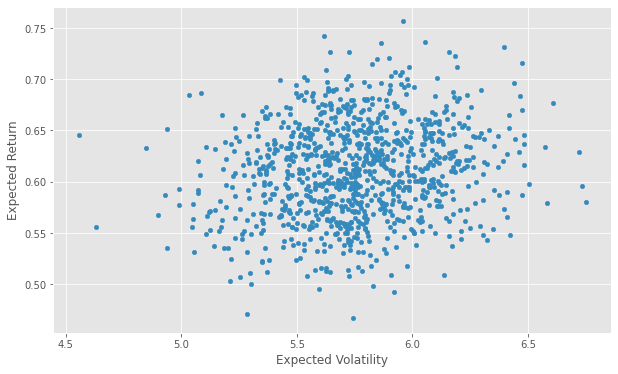

In [88]:
portfolios.plot(x='Volatility', y='Return',kind = 'scatter',figsize=(10,6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [91]:
import plotly.express as px
import plotly.graph_objects as go

In [103]:
n_obs = 1000
n_assets = len(ExpectedReturnDF_log_return.dropna().columns)

return_vec = ExpectedReturnDF_log_return.dropna().values

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

rand_weights(n_assets)

array([3.74185178e-03, 8.26641188e-03, 6.43829810e-03, 7.53914261e-03,
       9.52223247e-04, 3.40545115e-04, 1.04853822e-03, 2.33738071e-03,
       5.71752563e-03, 2.38599340e-04, 7.78932415e-03, 5.10878201e-03,
       4.91611878e-03, 5.88182977e-04, 7.03810631e-04, 8.12289327e-03,
       8.15406287e-03, 3.89073070e-03, 1.89654409e-03, 9.82126393e-04,
       4.70267265e-03, 1.27963197e-03, 4.85420248e-03, 6.67813464e-04,
       8.08949408e-03, 7.36592941e-03, 4.10083273e-03, 7.36280180e-03,
       8.16999054e-03, 6.66911083e-03, 1.75513106e-03, 2.82613775e-03,
       4.47562605e-03, 2.78454133e-03, 8.12876095e-03, 2.08958804e-03,
       8.08431430e-03, 9.25553163e-03, 1.88735185e-03, 2.15812917e-03,
       7.22540174e-03, 3.43109637e-03, 3.19097270e-03, 1.58987666e-03,
       9.53172215e-03, 1.08688444e-03, 3.98785606e-03, 2.99883068e-03,
       6.53941109e-04, 2.11941326e-03, 8.20219165e-03, 8.83227586e-03,
       5.80224158e-03, 6.46891170e-03, 1.11059239e-03, 5.98435642e-03,
      

In [104]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [115]:
n_portfolios = 10000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

In [116]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=means.squeeze(), y=stds.squeeze(),
            name='start value', mode="markers"
            ))
fig.update_layout(title="Random Portfolio",
            xaxis_title='Date',
            yaxis_title='Normalized value')
fig.show()

In [117]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

     pcost       dcost       gap    pres   dres
 0: -8.9179e+00 -5.5061e+00  3e+03  5e+01  4e+00
 1: -4.4982e+00 -3.5209e+00  1e+02  2e+00  2e-01
 2: -1.4988e+00 -1.7178e+00  1e+01  2e-01  2e-02
 3: -3.0105e-01 -1.2689e+00  1e+00  2e-16  6e-15
 4: -4.3131e-01 -8.6102e-01  4e-01  9e-16  4e-15
 5: -6.1356e-01 -7.9792e-01  2e-01  7e-16  2e-15
 6: -7.0357e-01 -7.5923e-01  6e-02  1e-16  2e-15
 7: -7.3921e-01 -7.5079e-01  1e-02  7e-16  2e-15
 8: -7.4882e-01 -7.4919e-01  4e-04  1e-16  3e-15
 9: -7.4916e-01 -7.4916e-01  5e-06  5e-17  3e-15
10: -7.4916e-01 -7.4916e-01  9e-08  2e-16  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.2522e+00 -5.2436e+00  3e+03  5e+01  4e+00
 1: -4.2079e+00 -3.3954e+00  1e+02  2e+00  2e-01
 2: -1.4256e+00 -1.7084e+00  1e+01  2e-01  2e-02
 3: -2.9773e-01 -1.2571e+00  1e+00  3e-17  6e-15
 4: -4.2541e-01 -8.4957e-01  4e-01  1e-17  4e-15
 5: -6.0686e-01 -7.8166e-01  2e-01  3e-17  2e-15
 6: -6.8800e-01 -7.4265e-01  5e-02  1e-16  2e-1

In [121]:
risks

[1.5983681392557691,
 1.5311153496929266,
 1.4700579489878625,
 1.4083650645411558,
 1.34668545994057,
 1.2769752985571847,
 1.206920191612419,
 1.1414818228444659,
 1.083406843911301,
 1.0326222196266217,
 0.9850158146605668,
 0.9385896828672705,
 0.8926854762532592,
 0.8496063562337579,
 0.8034706931575176,
 0.757740523633134,
 0.7121841811167868,
 0.6719816343389345,
 0.6387129049057306,
 0.6043608272490105,
 0.5697732480561626,
 0.5337442689086316,
 0.49808299498344655,
 0.463274140952056,
 0.4283288345055876,
 0.39558802582264313,
 0.36518014664764736,
 0.3367751541631754,
 0.31025444398816343,
 0.28646594762765365,
 0.2647970273560295,
 0.24415861914437628,
 0.22470126893215067,
 0.2070966948179795,
 0.19137643273165472,
 0.17797929055359565,
 0.16544661182126863,
 0.154345220599204,
 0.14397662301437114,
 0.13422756197992297,
 0.12506741906062688,
 0.1166066270810449,
 0.10865740038334716,
 0.10040106833180766,
 0.09141811744890985,
 0.08323932864224068,
 0.07561572508103148,
 0

In [118]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=means.squeeze(), y=stds.squeeze(),
            name='start value', mode="markers"
            ))
fig.add_trace(go.Scatter(x=returns, y=risks,
                    mode='lines',
                    name='Portfolio Value',
                    line = dict(color='firebrick')))
fig.update_layout(title="Random Portfolio",
            xaxis_title='Date',
            yaxis_title='Normalized value')
fig.show()

In [124]:
import matplotlib.pyplot as plt

In [123]:
weights.squeeze()

array([5.92398192e-10, 3.60762442e-10, 4.76641579e-10, ...,
       7.81746647e-10, 3.01088343e-10, 2.01423017e-09])

In [142]:
df = ExpectedReturnDF

cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

/home/mateusz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



ticker,AB INTER RAO LIETUVA,AB NOVATURAS,AIRWAY MEDIX SPOLKA AKCYJNA,AS SILVANO FASHION GROUP,ATREM SPOLKA AKCYJNA,BANCO SANTANDER S.A.,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,BANK MILLENNIUM SPOLKA AKCYJNA,BANK POLSKA KASA OPIEKI SPOLKA AKCYJNA,BBI DEVELOPMENT SPOLKA AKCYJNA,...,X-TRADE BROKERS DOM MAKLERSKI SPOLKA AKCYJNA,XTPL SPOLKA AKCYJNA,ZAKLAD BUDOWY MASZYN ZREMB-CHOJNICE SPOLKA AKCYJNA,ZAKLADY MAGNEZYTOWE ROPCZYCE SPOLKA AKCYJNA,ZAKLADY PRZEMYSLU CUKIERNICZEGO OTMUCHOW SPOLKA AKCYJNA,ZAMET INDUSTRY SPOLKA AKCYJNA,ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,ZPUE SPOLKA AKCYJNA,ZUE SPOLKA AKCYJNA
ticker,,,,,,,,,,,,,,,,,,,,,
AB INTER RAO LIETUVA,0.000572,0.000074,0.000019,-0.000014,0.000001,0.000042,0.000029,0.000061,6.251961e-05,0.000050,...,0.000054,0.000085,0.000039,0.000043,0.000038,2.462251e-05,6.452599e-05,0.000039,0.000089,0.000035
AB NOVATURAS,0.000074,0.002407,-0.000047,0.000254,0.000242,0.000164,0.000089,0.000207,8.765259e-05,0.000081,...,0.000126,-0.000046,-0.000017,0.000162,-0.000144,1.063315e-05,-1.794318e-05,0.000036,0.000038,-0.000099
AIRWAY MEDIX SPOLKA AKCYJNA,0.000019,-0.000047,0.002275,0.000092,0.000043,0.000061,-0.000017,0.000026,3.512354e-06,0.000048,...,0.000108,0.000140,0.000062,0.000058,0.000027,1.052789e-04,3.687969e-05,0.000026,0.000072,0.000114
AS SILVANO FASHION GROUP,-0.000014,0.000254,0.000092,0.001153,0.000046,0.000072,-0.000043,-0.000019,8.131401e-07,0.000005,...,0.000090,0.000116,0.000022,0.000005,0.000050,-1.185759e-05,1.479454e-05,0.000087,0.000005,-0.000021
ATREM SPOLKA AKCYJNA,0.000001,0.000242,0.000043,0.000046,0.000942,0.000066,0.000020,0.000027,3.386578e-05,-0.000021,...,-0.000019,0.000060,0.000038,0.000051,-0.000006,2.110967e-05,1.130749e-05,-0.000021,0.000010,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAMET INDUSTRY SPOLKA AKCYJNA,0.000025,0.000011,0.000105,-0.000012,0.000021,0.000054,0.000049,0.000026,4.122209e-05,0.000015,...,0.000038,-0.000047,0.000039,0.000007,0.000049,7.763622e-04,9.626593e-07,0.000016,0.000007,0.000054
ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,0.000065,-0.000018,0.000037,0.000015,0.000011,0.000053,0.000045,0.000080,6.494818e-05,0.000046,...,0.000035,0.000160,-0.000018,0.000050,0.000012,9.626593e-07,4.511923e-04,0.000055,0.000072,0.000033
ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,0.000039,0.000036,0.000026,0.000087,-0.000021,0.000083,0.000058,0.000111,8.253534e-05,0.000016,...,0.000114,0.000147,0.000084,0.000052,0.000015,1.604287e-05,5.478213e-05,0.000787,0.000069,0.000028


In [143]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

/home/mateusz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



ticker,AB INTER RAO LIETUVA,AB NOVATURAS,AIRWAY MEDIX SPOLKA AKCYJNA,AS SILVANO FASHION GROUP,ATREM SPOLKA AKCYJNA,BANCO SANTANDER S.A.,BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA,BANK MILLENNIUM SPOLKA AKCYJNA,BANK POLSKA KASA OPIEKI SPOLKA AKCYJNA,BBI DEVELOPMENT SPOLKA AKCYJNA,...,X-TRADE BROKERS DOM MAKLERSKI SPOLKA AKCYJNA,XTPL SPOLKA AKCYJNA,ZAKLAD BUDOWY MASZYN ZREMB-CHOJNICE SPOLKA AKCYJNA,ZAKLADY MAGNEZYTOWE ROPCZYCE SPOLKA AKCYJNA,ZAKLADY PRZEMYSLU CUKIERNICZEGO OTMUCHOW SPOLKA AKCYJNA,ZAMET INDUSTRY SPOLKA AKCYJNA,ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,ZPUE SPOLKA AKCYJNA,ZUE SPOLKA AKCYJNA
ticker,,,,,,,,,,,,,,,,,,,,,
AB INTER RAO LIETUVA,1.000000,0.069047,0.016494,-0.016288,0.001690,0.059645,0.064026,0.094461,0.130971,0.075211,...,0.059934,0.081271,0.033941,0.081757,0.047083,0.037347,0.125554,0.058650,0.133074,0.058705
AB NOVATURAS,0.069047,1.000000,-0.015206,0.124942,0.166378,0.120902,0.085552,0.149278,0.086266,0.056732,...,0.065228,-0.021286,-0.007292,0.142979,-0.072307,0.007939,-0.016350,0.031139,0.025746,-0.073021
AIRWAY MEDIX SPOLKA AKCYJNA,0.016494,-0.015206,1.000000,0.065253,0.029123,0.040575,-0.019413,0.020305,0.003699,0.037548,...,0.059135,0.065474,0.023635,0.055705,0.016978,0.082847,0.036291,0.019502,0.052343,0.096625
AS SILVANO FASHION GROUP,-0.016288,0.124942,0.065253,1.000000,0.047595,0.063044,-0.060517,-0.019182,0.001059,0.005709,...,0.083090,0.071219,0.016295,0.006392,0.040354,-0.011743,0.019688,0.088365,0.005129,-0.024164
ATREM SPOLKA AKCYJNA,0.001690,0.166378,0.029123,0.047595,1.000000,0.068380,0.033798,0.031867,0.054989,-0.025571,...,-0.016238,0.041756,0.023213,0.075161,-0.005947,0.023930,0.017658,-0.024241,0.011396,0.034666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAMET INDUSTRY SPOLKA AKCYJNA,0.037347,0.007939,0.082847,-0.011743,0.023930,0.069304,0.093262,0.033614,0.072735,0.019728,...,0.037842,-0.043174,0.031506,0.011185,0.052167,1.000000,0.001641,0.019861,0.009227,0.081632
ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA,0.125554,-0.016350,0.036291,0.019688,0.017658,0.079957,0.113122,0.140429,0.153542,0.078420,...,0.043152,0.165123,-0.017559,0.107424,0.017683,0.001641,1.000000,0.091820,0.118607,0.062816
ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA,0.058650,0.031139,0.019502,0.088365,-0.024241,0.096146,0.110270,0.146955,0.148084,0.021096,...,0.113310,0.128471,0.053734,0.084375,0.015690,0.019861,0.091820,1.000000,0.085268,0.039872


In [144]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

n_assets = len(df.columns)
weights = rand_weights(n_assets)

array([4.76427418e-03, 4.64184217e-03, 8.46005081e-03, 3.08858864e-03,
       2.92175344e-03, 4.26426506e-03, 2.75846693e-03, 7.37459422e-03,
       4.69198935e-03, 4.41813419e-03, 1.35619042e-03, 5.35333225e-03,
       5.18805458e-04, 2.93984741e-03, 5.03034344e-03, 8.28588038e-03,
       7.73889073e-03, 4.95478436e-04, 8.32035929e-03, 6.28784462e-03,
       5.69641603e-03, 6.74611599e-03, 5.22135137e-03, 3.96021140e-03,
       5.81123816e-03, 5.74219963e-03, 6.98820004e-03, 3.36967383e-03,
       7.46162402e-03, 5.93382045e-04, 2.09576096e-03, 2.59003349e-03,
       8.14681034e-03, 5.05440184e-03, 5.06218357e-03, 7.53183745e-03,
       8.08572657e-03, 1.41787981e-03, 5.53629415e-03, 8.02656048e-03,
       7.72464744e-05, 6.41853716e-03, 5.37023307e-03, 7.87245841e-03,
       6.06413182e-03, 6.44961111e-05, 7.44033447e-04, 1.58640129e-03,
       1.54612490e-03, 5.26678512e-03, 2.54203914e-03, 2.63436020e-03,
       6.74985000e-03, 8.38919235e-03, 7.94559362e-03, 6.92455997e-03,
      

In [148]:



ann_sd = df.pct_change().dropna().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

/home/mateusz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



ticker
AB INTER RAO LIETUVA                                               0.272889
AB NOVATURAS                                                            NaN
AIRWAY MEDIX SPOLKA AKCYJNA                                        0.686794
AS SILVANO FASHION GROUP                                                NaN
ATREM SPOLKA AKCYJNA                                               0.525886
                                                                     ...   
ZAMET INDUSTRY SPOLKA AKCYJNA                                           NaN
ZESPOL ELEKTROCIEPLOWNI WROCLAWSKICH KOGENERACJA SPOLKA AKCYJNA    0.447244
ZESPOL ELEKTROWNI PĄTNOW-ADAMOW-KONIN SPOLKA AKCYJNA                    NaN
ZPUE SPOLKA AKCYJNA                                                0.512222
ZUE SPOLKA AKCYJNA                                                 0.485426
Length: 222, dtype: float64